In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

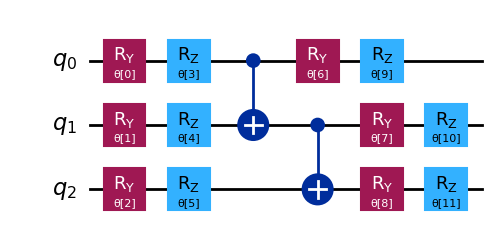

In [3]:
qc = EfficientSU2(3, reps=1, entanglement='linear')
qc = qc.decompose()
qc.draw("mpl")

In [4]:
list_parameter = []

for a in qc._data:
    list_parameter.append(str(a.operation.params))
pos_param = []
for param in range(qc.num_parameters):
    pos_param.append(list_parameter.index(f'[ParameterVectorElement(θ[{param}])]'))


In [5]:
qc._data[0]

CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(θ[0])]), qubits=(Qubit(QuantumRegister(3, 'q'), 0),), clbits=())

In [7]:
for i in range(qc.num_parameters):
	qc_internal = QuantumCircuit(3)

	if qc[pos_param[i]].operation.name == 'rx':
		qc_internal.x(qc._data[pos_param[i]].qubits[0]._index)
	if qc[pos_param[i]].operation.name == 'ry':
		qc_internal.y(qc._data[pos_param[i]].qubits[0]._index)
	if qc[pos_param[i]].operation.name == 'rz':
		qc_internal.z(qc._data[pos_param[i]].qubits[0]._index)

	qc_copy = qc.copy()
	qc_copy._data[pos_param[i]:pos_param[i]] = qc_internal[:]
	print(qc_copy)

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐»
q_0: ───┤ Y ├────┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘┌─┴─┐└──────────┘├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├────────────┤ X ├─────■──────┤ Ry(θ[7]) ├»
     ├──────────┤├──────────┤            └───┘   ┌─┴─┐    ├──────────┤»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────────────────────┤ X ├────┤ Ry(θ[8]) ├»
     └──────────┘└──────────┘                    └───┘    └──────────┘»
«                  
«q_0: ─────────────
«     ┌───────────┐
«q_1: ┤ Rz(θ[10]) ├
«     ├───────────┤
«q_2: ┤ Rz(θ[11]) ├
«     └───────────┘
     ┌──────────┐┌──────────┐                 ┌──────────┐┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──────────────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├»
     └──┬───┬───┘├──────────┤┌──────────┐┌─┴─┐└──────────┘├──────────┤»
q_1: ───┤ Y ├────┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐    ├─────────

In [8]:
import qiskit
import typing
import numpy as np
def loss_new(
    u: qiskit.QuantumCircuit,
    vdagger: qiskit.QuantumCircuit, # numpy array?
    thetass: typing.List[np.ndarray],
):

    f = (np.abs(np.trace(
        qiskit.quantum_info.Operator(u.assign_parameters(thetass)).data.transpose().conjugate() @ 
        qiskit.quantum_info.Operator(vdagger).data) / 2**u.num_qubits))**2
    return 1 - f


def derivative_loss_new(
    u: qiskit.QuantumCircuit,
    vdagger: qiskit.QuantumCircuit, # numpy array ?
    thetass: typing.List[np.ndarray],
) -> typing.List:

    internal_gradient = np.zeros(u.num_parameters)
    # Support for the following step
    list_parameter = []
    for data in u._data:
        list_parameter.append(str(data.operation.params))

    # Position of parameter gate in quantum circuit
    pos_param = []
    for param in range(u.num_parameters):
        pos_param.append(list_parameter.index(f'[ParameterVectorElement(θ[{param}])]'))

    # Update quantum circuit
    for i in range(u.num_parameters):
        qc_internal = QuantumCircuit(u.num_qubits)

        if u[pos_param[i]].operation.name == 'rx':
            qc_internal.x(u._data[pos_param[i]].qubits[0]._index)
        if u[pos_param[i]].operation.name == 'ry':
            qc_internal.y(u._data[pos_param[i]].qubits[0]._index)
        if u[pos_param[i]].operation.name == 'rz':
            qc_internal.z(u._data[pos_param[i]].qubits[0]._index)

        qc_copy = u.copy()
        qc_copy._data[pos_param[i]:pos_param[i]] = qc_internal[:]

        internal_gradient[i] = 1/4**(u.num_qubits) * np.imag(np.conjugate(np.trace(
            qiskit.quantum_info.Operator(qc_copy.assign_parameters(thetass)).data.transpose().conjugate() @ 
            qiskit.quantum_info.Operator(vdagger).data))
                                  * np.trace(qiskit.quantum_info.Operator(u.assign_parameters(thetass)).data.transpose().conjugate() @ 
                                             qiskit.quantum_info.Operator(vdagger).data))
    return internal_gradient


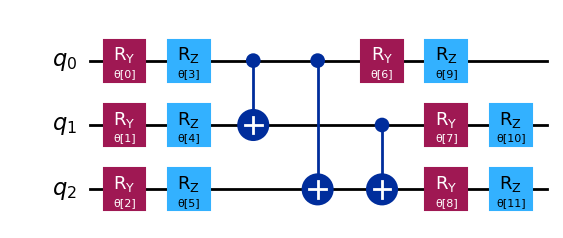

In [41]:
qc = EfficientSU2(3, reps=1, entanglement="full")
qc = qc.decompose()
qc.draw("mpl")

In [43]:
def optimize(qc: qiskit.QuantumCircuit):
    v_dagger = np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 1., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 0., 1.],
                   [0., 0., 0., 0., 1., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 1., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 1., 0.],
                   [0., 0., 0., 1., 0., 0., 0., 0.]]) + 0j
    fidelities = []
	alpha = 0.5
	thetass = np.zeros(qc.num_parameters) + np.pi/3
	fidelities.append(loss_new(qc, v_dagger, thetass))
	m_grad = np.zeros(qc.num_parameters)
	v_grad = np.zeros(qc.num_parameters)

	beta1 = 0.9
	beta2 = 0.999
	epsilon = 1e-8

	for iter in range(1000):
		internal_derivative_loss = derivative_loss_new(qc, v_dagger, thetass)
		# --- Adam optimizer --- #
		m_grad = beta1 * m_grad + (1 - beta1) * internal_derivative_loss
		v_grad = beta2 * v_grad + (1 - beta2) * internal_derivative_loss ** 2
		mhat = m_grad / (1 - beta1 ** (iter + 1))
		vhat = v_grad / (1 - beta2 ** (iter + 1))
		thetass += alpha * mhat / (np.sqrt(vhat) + epsilon)
		# --- Adam optimizer --- #
		fidelities.append(loss_new(qc, v_dagger, thetass))
		print(fidelities[-1])
		if np.abs(fidelities[-1] - fidelities[-2]) < 1e-12:
			break
	return fidelities[-1]


0.914214905623922
0.8041325112966158
0.8067228576653434
0.7650480904282566
0.6846541635149523
0.682923519815946
0.7213916314032589
0.7078334569893192
0.6685072565363649
0.6501338677796997
0.6591132758697764
0.6756223669115065
0.6717092568191865
0.65857986844308
0.6592554898936365
0.6632657585132744
0.6595230657887929
0.6537557467741719
0.6516829493358677
0.6510264650563756
0.6499704330734246
0.6491466239843118
0.6484228436406918
0.6469690649057098
0.6436890339108543
0.6401887515269218
0.6399352827182059
0.6413767958442984
0.6414654256854071
0.6414328590935081
0.6415484099724043
0.6399879319955981
0.6384225542997429
0.6393852199764323
0.6407306477725677
0.6396427381217427
0.6376277066725673
0.6371331516070038
0.6378072303244173
0.6378574124441725
0.6370892627106732
0.636907564954128
0.6371723611568993
0.6369127824830961
0.6367163711255615
0.6370084812551798
0.6371072257642072
0.6367784173645388
0.636437920165424
0.6363450242763413
0.6363639629806541
0.6363230482634321
0.6362540286158376

In [44]:
qiskit.quantum_info.Operator(qc.assign_parameters(thetas)).data.transpose().conjugate().real

array([[-3.53550367e-01,  1.69502472e-07,  8.53553944e-01,
        -5.38016213e-08,  3.53554999e-01, -6.54042882e-08,
         1.46446803e-01,  3.38884976e-08],
       [-1.57899558e-07, -8.53553066e-01,  8.18137006e-08,
        -3.53552485e-01,  7.02106603e-08,  1.46446187e-01,
        -2.22854396e-08, -3.53555254e-01],
       [ 1.46449052e-01, -7.02111122e-08, -3.53554067e-01,
         2.22857547e-08,  8.53553558e-01, -1.57899339e-07,
         3.53551298e-01,  8.18137348e-08],
       [ 6.54050455e-08,  3.53556185e-01, -3.38886950e-08,
         1.46443938e-01,  1.69502880e-07,  3.53551553e-01,
        -5.38016370e-08, -8.53553452e-01],
       [ 3.53555254e-01, -6.54045785e-08,  1.46446187e-01,
         3.38884668e-08, -3.53552485e-01,  1.69502844e-07,
         8.53553066e-01, -5.38017755e-08],
       [ 7.02107046e-08,  1.46446803e-01, -2.22853306e-08,
        -3.53554999e-01, -1.57900027e-07, -8.53553944e-01,
         8.18138138e-08, -3.53550367e-01],
       [ 8.53553452e-01, -1.578996

In [37]:
qiskit.quantum_info.Operator(v_dagger).data

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

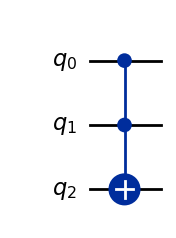

In [45]:
toffoli = QuantumCircuit(3)
toffoli.ccx(0, 1, 2)
toffoli.draw("mpl")

In [48]:
np.abs(np.trace(qiskit.quantum_info.Operator(qc.assign_parameters(thetas)).data.transpose().conjugate() @ qiskit.quantum_info.Operator(v_dagger).data)  / 2**3)**2

0.36427669529019147

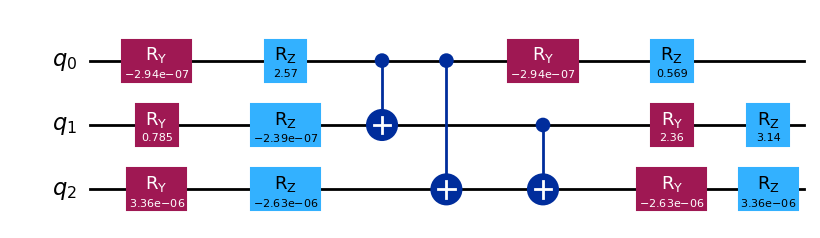

In [49]:
qc.assign_parameters(thetas).draw("mpl")

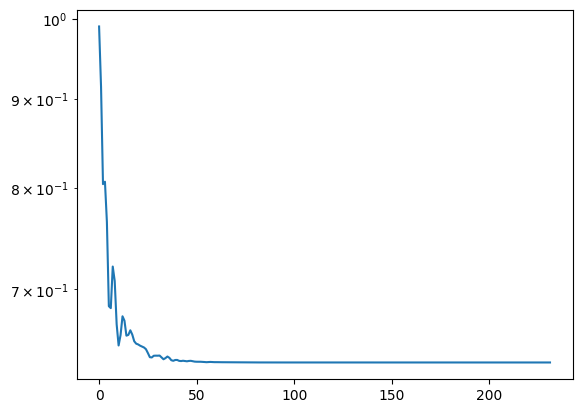

In [50]:
import matplotlib.pyplot as plt

plt.plot(fidelities)
plt.yscale('log')
plt.show()

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


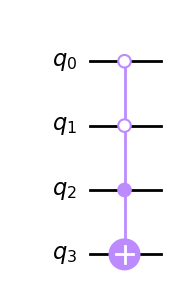

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate

toffoli_gate = QuantumCircuit(4)

ch_gate = XGate().control(3, ctrl_state="11")

toffoli_gate.append(ch_gate, [0, 1, 2, 3])

toffoli_gate.draw("mpl")

In [ ]:
SparsePauliOp.from_operator(matrix)

SparsePauliOp(['III', 'IIX', 'IZI', 'IZX', 'ZII', 'ZIX', 'ZZI', 'ZZX'],
              coeffs=[ 0.75+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
 -0.25+0.j,  0.25+0.j])

In [ ]:
# diagonolaize matrix
eigenvalues, eigenvectors = np.linalg.eig(matrix)

In [ ]:
# transform arbitrary matrix V to e^(-iH) form, transform_matrix equivalents to H in this case
transform_matrix = eigenvectors @ np.diag(np.log(eigenvalues + 0j)) @ eigenvectors.transpose().conjugate() / (-1j)
print(transform_matrix)

[[-0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j]
 [-0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j]
 [-0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j]
 [-0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j -1.57079633-2.77555756e-16j
  -0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.        -0.00000000e+00j  1.57079633-1.66533454e-16j]
 [-0.        -0.00000000e+00j -0.        -0.00000000e+00j
  -0.     

In [ ]:
import spicy
# compare old matrix (Test if there are any mistakes in coding)
np.linalg.norm(spicy.linalg.expm(transform_matrix*(-1j)) - matrix)

ModuleNotFoundError: No module named 'spicy'

In [ ]:
# Transform H matrix to sum of tensor operators
transform_observable = SparsePauliOp.from_operator(transform_matrix)
print(transform_observable)

SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'XII', 'XIZ', 'XZI', 'XZZ'],
              coeffs=[-0.39269908-6.93889390e-17j,  0.39269908+6.93889390e-17j,
  0.39269908+6.93889390e-17j, -0.39269908-6.93889390e-17j,
  0.39269908-4.16333634e-17j, -0.39269908+4.16333634e-17j,
 -0.39269908+4.16333634e-17j,  0.39269908-4.16333634e-17j])


In [ ]:
# Use Cartan-decomposition algorithm (Under construction)
from Exact_time_evolution import Cartan_decomposition

cartan_Hamilton = Cartan_decomposition(transform_observable)

cartan_Hamilton.decomposition()

SparsePauliOp(['IIX', 'IZI', 'IZX', 'ZII', 'ZIX', 'ZZI', 'ZZX'],
              coeffs=[  1.        +0.j,   3.14159265+0.j,   9.8696044 +0.j,  31.00627668+0.j,
  97.40909103+0.j, 306.01968479+0.j, 961.38919358+0.j])

In [ ]:
cartan_Hamilton.Hamiltonian_algebra

[SparsePauliOp(['IIX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZX'],
               coeffs=[1.+0.j])]

In [ ]:
interation = 1000

initial_point = np.zeros(len(cartan_Hamilton.l_list)) + np.pi/2
learning_rate = 0.1
threshold = 1e-16
verbose = 2

cartan_Hamilton.optimization(interation, initial_point, learning_rate, threshold, verbose)
### Error due to the commutable feature between operators in Hamiltonian_algebra

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
(transform_observable - SparsePauliOp(['III'], coeffs=[-0.39269908-6.93889390e-17j])).simplify()

SparsePauliOp(['IIX', 'IZI', 'IZX', 'ZII', 'ZIX', 'ZZI', 'ZZX'],
              coeffs=[ 0.39269908-4.16333634e-17j,  0.39269908+6.93889390e-17j,
 -0.39269908+4.16333634e-17j,  0.39269908+6.93889390e-17j,
 -0.39269908+4.16333634e-17j, -0.39269908-6.93889390e-17j,
  0.39269908-4.16333634e-17j])

In [ ]:
remove_identity_operator = (transform_observable - SparsePauliOp(['III'], coeffs=[-0.39269908-6.93889390e-17j])).simplify()
remove_identity_operator.coeffs = remove_identity_operator.coeffs.real
print(remove_identity_operator)

SparsePauliOp(['IIZ', 'IZI', 'IZZ', 'XII', 'XIZ', 'XZI', 'XZZ'],
              coeffs=[ 0.39269908+0.j,  0.39269908+0.j, -0.39269908+0.j,  0.39269908+0.j,
 -0.39269908+0.j, -0.39269908+0.j,  0.39269908+0.j])


In [ ]:
np.pi/8

0.39269908169872414

In [ ]:
from qiskit.quantum_info import Operator


trial_quantum_circuit = QuantumCircuit(3)

trial_quantum_circuit.rz(-np.pi/4, 0)
trial_quantum_circuit.rz(-np.pi/4, 1)
trial_quantum_circuit.rx(-np.pi/4, 2)

trial_quantum_circuit.h(2)
trial_quantum_circuit.cx(0, 2)
trial_quantum_circuit.rz(np.pi/4, 2)
trial_quantum_circuit.cx(1, 2)
trial_quantum_circuit.cx(0, 1)
trial_quantum_circuit.rz(np.pi/4, 1)
trial_quantum_circuit.rz(-np.pi/4, 2)

trial_quantum_circuit.cx(0, 2)
trial_quantum_circuit.cx(0, 1)

trial_quantum_circuit.rz(np.pi/4, 2)
trial_quantum_circuit.cx(1, 2)
trial_quantum_circuit.h(2)


print(trial_quantum_circuit)
print(Operator(trial_quantum_circuit).data.real)

     ┌──────────┐                                                      »
q_0: ┤ Rz(-π/4) ├───────■───────────────────────■───────────────────■──»
     ├──────────┤       │                     ┌─┴─┐    ┌─────────┐  │  »
q_1: ┤ Rz(-π/4) ├───────┼───────────────■─────┤ X ├────┤ Rz(π/4) ├──┼──»
     ├──────────┤┌───┐┌─┴─┐┌─────────┐┌─┴─┐┌──┴───┴───┐└─────────┘┌─┴─┐»
q_2: ┤ Rx(-π/4) ├┤ H ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├───────────┤ X ├»
     └──────────┘└───┘└───┘└─────────┘└───┘└──────────┘           └───┘»
«                          
«q_0: ─────■───────────────
«        ┌─┴─┐             
«q_1: ───┤ X ├─────■───────
«     ┌──┴───┴──┐┌─┴─┐┌───┐
«q_2: ┤ Rz(π/4) ├┤ X ├┤ H ├
«     └─────────┘└───┘└───┘
[[ 9.23879533e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.55111512e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.23879533e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.000000

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


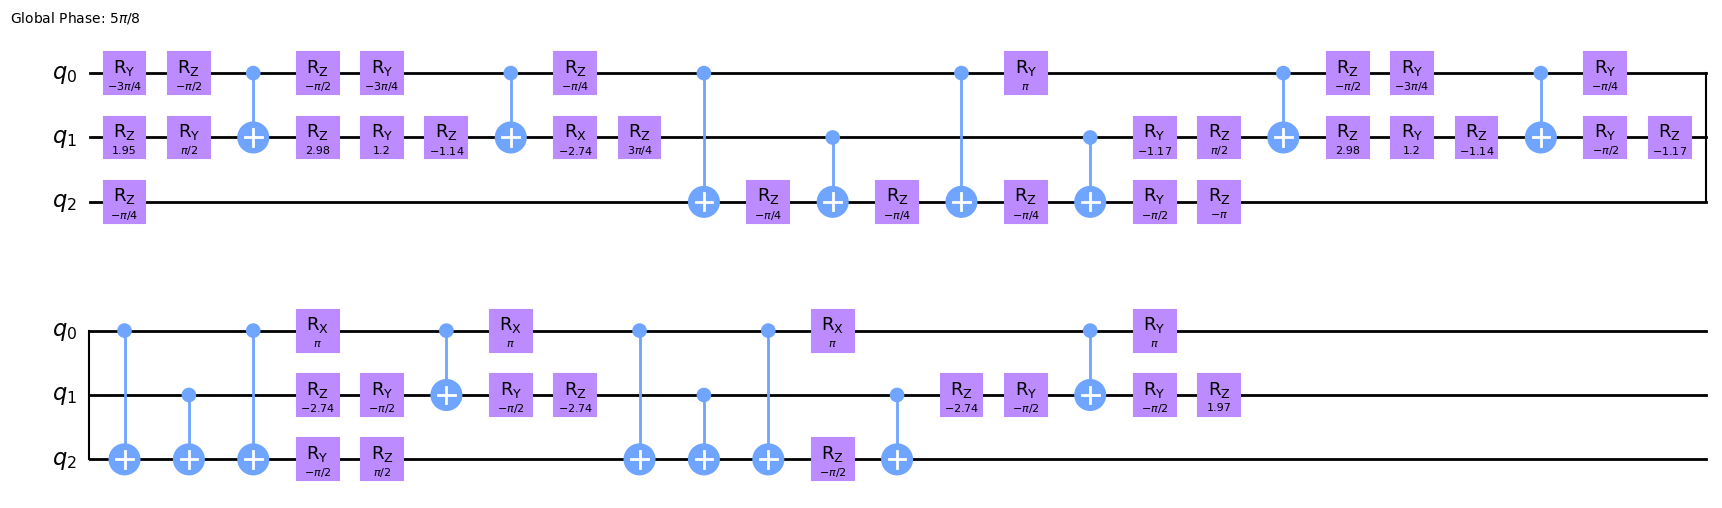

In [ ]:
# Qiskit transpile unitary

qc = QuantumCircuit(3)
qc.unitary(matrix, [0, 1, 2])

transpile_qc = transpile(qc, basis_gates=['h', 'cx', 'rx', 'ry', 'rz'])

transpile_qc.draw("mpl")

Fidelity of found circuit with qiskit transpile circuit

In [ ]:
from qiskit.quantum_info import Operator

U = Operator(quantum_circuit)

qiskit_U = Operator(transpile_qc)

# Show the matrix form results
zeros_state = np.array([1] + [0]*7)

vector_U = U.data @ zeros_state
print(vector_U)
vector_qiskit = qiskit_U.data @ zeros_state
print(vector_qiskit)

print("Fidelity with qiskit: ", np.abs(vector_U.dot(vector_qiskit.conjugate().transpose()))**2)

[0.92387953-3.82683432e-01j 0.        +8.32667268e-17j
 0.        +0.00000000e+00j 0.        +0.00000000e+00j
 0.        +0.00000000e+00j 0.        +0.00000000e+00j
 0.        +0.00000000e+00j 0.        +0.00000000e+00j]
[ 1.00000000e+00-3.94129174e-15j -9.10009535e-17-3.22628464e-16j
 -6.48557029e-16+4.28188523e-16j -2.09710949e-16-4.43579261e-16j
 -7.85046229e-17+6.16297582e-33j  2.65964317e-32+9.16490376e-33j
 -7.03562477e-32+6.12204089e-32j -5.22945840e-32-1.74315280e-32j]
Fidelity with qiskit:  [1.00000000e+00 1.74741700e-31 6.03971631e-31 2.40741243e-31
 6.16297582e-33 8.77367359e-64 3.03858168e-63 8.69794006e-63]


Fidelity of Toffoli circuit with qiskit transpile circuit

In [ ]:
from qiskit.quantum_info import Operator

qiskit_U = Operator(transpile_qc)

# Show the matrix form results
zeros_state = np.array([1] + [0]*7)

vector_qiskit = qiskit_U.data @ zeros_state
print(vector_qiskit)
vector_matrix = matrix @ zeros_state
print(vector_matrix)

print("Fidelity: ", np.abs(vector_qiskit.dot(vector_matrix.conjugate().transpose())))

[ 1.00000000e+00-3.94129174e-15j -9.10009535e-17-3.22628464e-16j
 -6.48557029e-16+4.28188523e-16j -2.09710949e-16-4.43579261e-16j
 -7.85046229e-17+6.16297582e-33j  2.65964317e-32+9.16490376e-33j
 -7.03562477e-32+6.12204089e-32j -5.22945840e-32-1.74315280e-32j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Fidelity:  0.9999999999999992


In [ ]:

print("Fidelity of qiskit:", np.abs(np.trace(qiskit_U.data.transpose().conjugate() @ matrix) / 2**3)**2)
print("Fidelity of our calculation:", np.abs(np.trace(U.data.transpose().conjugate() @ matrix) / 2**3)**2)

Fidelity of qiskit: 0.9999999999999991
Fidelity of our calculation: 0.9999999999999991


In [ ]:
np.abs(np.trace(qiskit_U.data.transpose().conjugate() @ matrix) / 2**3)**2 - np.abs(np.trace(U.data.transpose().conjugate() @ matrix) / 2**3)**2

0.0

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


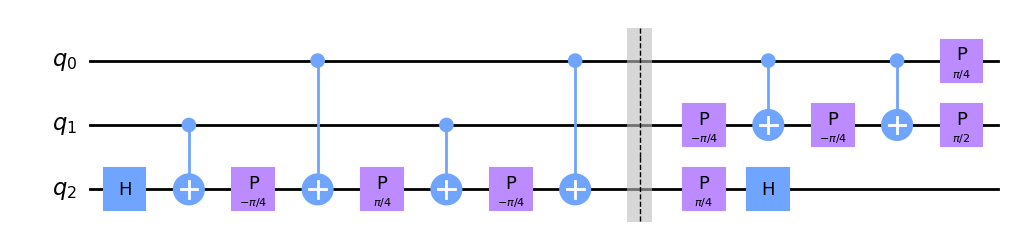

In [ ]:
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(3)

qc.h(2)
qc.cx(1, 2)
qc.p(-np.pi/4, 2)
qc.cx(0, 2)
qc.p(np.pi/4, 2)
qc.cx(1, 2)
qc.p(-np.pi/4, 2)
qc.cx(0, 2)

qc.barrier()

qc.p(-np.pi/4, 1)
qc.p(np.pi/4, 2)


qc.cx(0,1)
qc.h(2)

qc.p(-np.pi/4, 1)

qc.cx(0,1)

qc.p(np.pi/4, 0)
qc.p(np.pi/2, 1)

qc.draw("mpl")

In [ ]:
print(qc.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw & \qw & \qw & \ctrl{2} & \qw & \qw & \qw & \ctrl{2} \barrier[0em]{2} & \qw & \qw & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{P}\,(\mathrm{\frac{\pi}{4}})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \ctrl{1} & \qw & \qw & \qw & \ctrl{1} & \qw & \qw & \qw & \gate{\mathrm{P}\,(\mathrm{\frac{-\pi}{4}})} & \targ & \gate{\mathrm{P}\,(\mathrm{\frac{-\pi}{4}})} & \targ & \gate{\mathrm{P}\,(\mathrm{\frac{\pi}{2}})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{H}} & \targ & \gate{\mathrm{P}\,(\mathrm{\frac{-\pi}{4}})} & \targ & \gate{\mathrm{P}\,(\mathrm{\frac{\pi}{4}})} & \targ & \gate{\mathrm{P}\,(\mathrm{\frac{-\pi}{4}})} & \targ & \qw & \gate{\mathrm{P}\,(\mathrm{\frac{\pi}{4}})} & \gate{\mathrm{H}} & \qw & \qw & \qw &

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


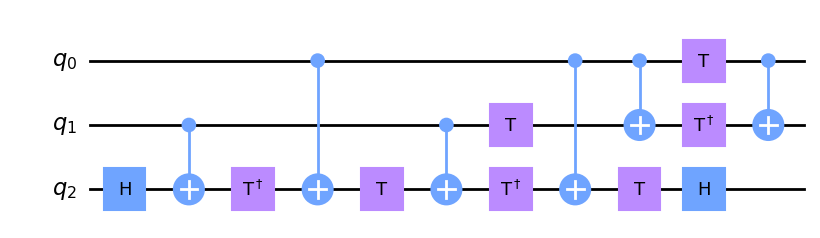

In [ ]:
from qiskit.circuit import QuantumCircuit

ccx_circ = QuantumCircuit(3)
ccx_circ.ccx(0, 1, 2)
ccx_circ.decompose().draw(output='mpl')

In [ ]:
print(ccx_circ.decompose().draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw & \qw & \qw & \ctrl{2} & \qw & \qw & \qw & \ctrl{2} & \ctrl{1} & \gate{\mathrm{T}} & \ctrl{1} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \ctrl{1} & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{T}} & \qw & \targ & \gate{\mathrm{T^\dagger}} & \targ & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{H}} & \targ & \gate{\mathrm{T^\dagger}} & \targ & \gate{\mathrm{T}} & \targ & \gate{\mathrm{T^\dagger}} & \targ & \gate{\mathrm{T}} & \gate{\mathrm{H}} & \qw & \qw & \qw\\
\\ }}
\end{document}


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


In [ ]:
from qiskit.quantum_info import Operator

qc_U = Operator(qc)

print("Fidelity of qc:", np.abs(np.trace(qc_U.data.transpose().conjugate() @ toffoli_gate_U.data) / 2**3)**2)

Fidelity of qc: 0.9999999999999996


In [ ]:
qc_U.data.real

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.92523115e-17, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.19399952e-32,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.92523115e-17, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.

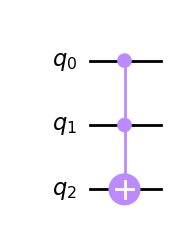

In [ ]:
toffoli_gate = QuantumCircuit(3)

toffoli_gate.ccx(0, 1, 2)

toffoli_gate.draw("mpl")

In [ ]:
print(toffoli_gate.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.8em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \ctrl{1} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ctrl{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \targ & \qw & \qw\\
\\ }}
\end{document}


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


In [ ]:
toffoli_gate_U = Operator(toffoli_gate)

print(toffoli_gate_U.data.real)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
pool = Qubit_Excitation_pool([3,2], 8)

In [ ]:
print(pool["basis_state"][0])
print(pool["excitation_type"][0])
print(pool["position"][0])

10011011
double
[2, 5, 3, 7]


In [ ]:
from itertools import permutations
from qiskit.quantum_info import SparsePauliOp,Pauli

def general_excitation_gate(number_of_qubit, theta=None):
  # theta = Parameter('?')
  if theta == None:
    theta = 0
  quantum_register = QuantumRegister(number_of_qubit)
  quantum_circuit = QuantumCircuit(quantum_register)

  ch_gate = XGate().control(number_of_qubit-1, ctrl_state="0"*int((number_of_qubit-2)/2) + "1" + "0"*int((number_of_qubit-2)/2) )

  # Construct BLOCK 1 CNOT
  if  number_of_qubit >= 4:
    for i in range(1, int(number_of_qubit/2)):
      quantum_circuit.cx(0, i)
  else:
    quantum_circuit.cx(0,1)

  if number_of_qubit >= 4:
    for i in range(1, int(number_of_qubit/2)):
      quantum_circuit.cx(int(number_of_qubit/2), i+int(number_of_qubit/2))

  if number_of_qubit >= 4:
    quantum_circuit.cx(0, int(number_of_qubit/2))


  quantum_circuit.append(ch_gate, list((np.linspace(1, number_of_qubit-1, number_of_qubit-1)).astype(int)) + [0])
  quantum_circuit.ry(theta*-1/2, 0)
  quantum_circuit.append(ch_gate, list((np.linspace(1, number_of_qubit-1, number_of_qubit-1)).astype(int)) + [0])
  quantum_circuit.ry(theta/2, 0)

  if number_of_qubit >= 4:
    quantum_circuit.cx(0, int(number_of_qubit/2))

  # Construc BLOCK 2 CNOT
  if  number_of_qubit >= 4:
    for i in range(int(number_of_qubit/2)-1, 0, -1):
      quantum_circuit.cx(0, i)
  else:
    quantum_circuit.cx(0,1)

  if number_of_qubit >= 4:
    for i in range(int(number_of_qubit/2)-1, 0, -1):
      quantum_circuit.cx(int(number_of_qubit/2), i+int(number_of_qubit/2))
  return quantum_circuit

def Qubit_Excitation_pool(num_particles, num_qubits, restricted=None):
  perm_alpha = set(permutations(["1"]*num_particles[0] + ["0"]*int(num_qubits/2-num_particles[0])))
  string_elements_alpha = [''.join(element) for element in perm_alpha]

  perm_beta = set(permutations(["1"]*num_particles[1] + ["0"]*int(num_qubits/2-num_particles[1])))
  string_elements_beta = [''.join(element) for element in perm_beta]

  base_state = (''.join(["1"]*num_particles[0] + ["0"]*int(num_qubits/2-num_particles[0]) + ["1"]*num_particles[1] + ["0"]*int(num_qubits/2-num_particles[1])))[::-1]
  # print(f"HF: {base_state}")
  basis_data = {"basis_state": [], "excitation_operators": [], "position": [], "excitation_type": [], "pool_type": []}


  # Define pauli operator by SparsePauliOp
  sigma_plus = SparsePauliOp(["X", "Y"], coeffs=[1/2, -1j/2,], )
  sigma_minus = SparsePauliOp(["X", "Y"], coeffs=[1/2, 1j/2,],)
  I = SparsePauliOp(["I"], coeffs=[1,],)

  for i in range(len(string_elements_alpha)):
    for j in range(len(string_elements_beta)):
      basis_data["basis_state"].append(string_elements_beta[j] + string_elements_alpha[i])

  # Remove Hatree-Fock State
  basis_data["basis_state"].remove(base_state)

  # Type_of_state
  position_count = []
  for i in range(0, num_particles[0]):
    position_count.append(i)
  for i in range(int(num_qubits/2), num_particles[1] + int(num_qubits/2)):
    position_count.append(i)
  # print(position_count)


  for i in range(len(basis_data["basis_state"])):
    check_excitation = 0
    for j in position_count:
      if basis_data["basis_state"][i][::-1][j] == "0":
        check_excitation += 1
    # print(basis_data["basis_state"][i])
    # print(check_excitation)
    if check_excitation == 1:
      basis_data["excitation_type"].append("single")
    elif check_excitation == 2:
      basis_data["excitation_type"].append("double")
    elif check_excitation == 3:
      basis_data["excitation_type"].append("triple")
    elif check_excitation == 4:
      basis_data["excitation_type"].append("quadruple")
    elif check_excitation == 5:
      basis_data["excitation_type"].append("quintuple")
    elif check_excitation == 6:
      basis_data["excitation_type"].append("sextuple")
    elif check_excitation == 7:
      basis_data["excitation_type"].append("septuple")
    elif check_excitation == 8:
      basis_data["excitation_type"].append("octuple")
    else:
      basis_data["excitation_type"].append("Unknown")

  # Retricted to single and double
  if restricted == "single_double_excitation":
    non_single_double_excitation_state = []
    for i in range(len(basis_data["excitation_type"])):
      if basis_data["excitation_type"][i] != "single" and basis_data["excitation_type"][i] != "double":
        non_single_double_excitation_state.append(basis_data["basis_state"][i])
    # print(non_single_double_excitation_state)
    for state in (non_single_double_excitation_state):
      basis_data["excitation_type"].pop(basis_data["basis_state"].index(state))
      basis_data["basis_state"].remove(state)

  #Retricted to single, double, triple and quadruple
  if restricted == "single_double_triple_quadruple_excitation":
    non_single_double_excitation_state = []
    for i in range(len(basis_data["excitation_type"])):
      if basis_data["excitation_type"][i] != "single" and basis_data["excitation_type"][i] != "double" and basis_data["excitation_type"][i] != "triple" and basis_data["excitation_type"][i] != "quadruple":
        non_single_double_excitation_state.append(basis_data["basis_state"][i])
    # print(non_single_double_excitation_state)
    for state in (non_single_double_excitation_state):
      basis_data["excitation_type"].pop(basis_data["basis_state"].index(state))
      basis_data["basis_state"].remove(state)

  for _ in range(len(basis_data["basis_state"])):
    basis_data["pool_type"].append("QubitExcitationBased")

  # Exciation_operator
  for state in basis_data["basis_state"]:
    operator = I.copy()
    reverse_state = state[::-1]
    for i in range(len(reverse_state)):
      if i == 0:
        if reverse_state[i] == '1' and base_state[::-1][i] == '0':
          operator = sigma_plus
        if reverse_state[i] == '0' and base_state[::-1][i] == '1':
          operator = sigma_minus
      else:
        if reverse_state[i] == '1' and base_state[::-1][i] == '0':
          operator = operator.expand(sigma_plus)
        elif reverse_state[i] == '0' and base_state[::-1][i] == '1':
          operator = operator.expand(sigma_minus)
        else:
          operator = operator.expand(I)

    basis_data["excitation_operators"].append((operator - operator.conjugate().transpose()).simplify())

  # Position of annhilation and creation operator
  for state in basis_data["basis_state"]:
    position_annhilation = []
    position_creation = []

    for i in range(0, num_particles[0]):
      initial_base_state = base_state[::-1]
      initial_basis_data = state[::-1]

      if initial_base_state[i] != initial_basis_data[i]:
        position_annhilation.append(i)

    for i in range(int(num_qubits/2), int(num_qubits/2)+num_particles[1]):
      initial_base_state = base_state[::-1]
      initial_basis_data = state[::-1]

      if initial_base_state[i] != initial_basis_data[i]:
        position_annhilation.append(i)

    for i in range(num_particles[0], int(num_qubits/2)):
      initial_base_state = base_state[::-1]
      initial_basis_data = state[::-1]

      if initial_base_state[i] != initial_basis_data[i]:
        position_creation.append(i)

    for i in range(int(num_qubits/2)+num_particles[1], num_qubits):
      initial_base_state = base_state[::-1]
      initial_basis_data = state[::-1]

      if initial_base_state[i] != initial_basis_data[i]:
        position_creation.append(i)

    position = position_annhilation + position_creation

    basis_data["position"].append(position)

  return basis_data